In [1]:
# Libraries to be imported for this script

import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import generic_filter
from scipy.spatial import cKDTree
from shapely.geometry import Point


   OBJECTID       ID  year crop_name  pred_prob  area_ha  yield  production  \
0     12594  5162701  2020     WHEAT       0.54     27.6   1.60          44   
1     12595  5159362  2020     WHEAT       0.70     15.1   1.41          21   
2     12596  5052901  2020     WHEAT       0.82      4.9   2.06          10   
3     12597  5229249  2020     WHEAT       0.82     83.8   1.72         144   
4     12598  5158310  2020     WHEAT       0.61      6.9   1.42          10   

     lga_name  Shape__Area  Shape__Length  \
0  Quairading     0.000026       0.020774   
1  Quairading     0.000014       0.017254   
2  Quairading     0.000005       0.008911   
3  Quairading     0.000080       0.045273   
4  Quairading     0.000007       0.011684   

                                            geometry  
0  MULTIPOLYGON (((117.32587 -32.2202, 117.32562 ...  
1  MULTIPOLYGON (((117.46268 -32.07089, 117.46344...  
2  MULTIPOLYGON (((117.38981 -32.18736, 117.38952...  
3  MULTIPOLYGON (((117.66897 -31.9

<Axes: >

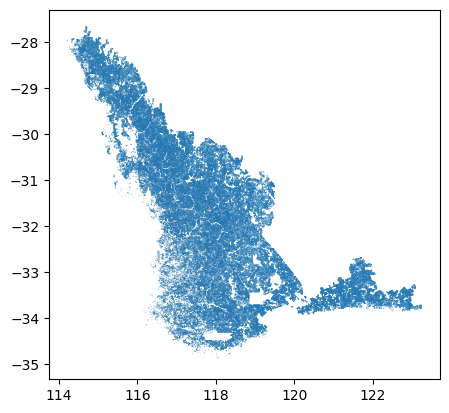

In [ ]:
# Reading .gpkg  file having WA paddocks Boundaries

path = "C://Users//M.Ibrah//Downloads//ggg.gpkg"
# Replace 'your_file.gpkg' with the path to your GeoPackage file
gdf = gpd.read_file(path)

# If your GeoPackage contains multiple layers, specify the layer name
# gdf = gpd.read_file("your_file.gpkg", layer="layer_name")

# Display the first few rows of the GeoDataFrame
print(gdf.head())

# Optionally, plot the geometries
gdf.plot()


In [3]:

def sort_gdf_and_find_centroids(gdf, year_column):
    # Step 1: Sort the GeoDataFrame by the year column
    gdf_sorted = gdf.sort_values(by=year_column)
    
    # Step 2: Group the sorted GeoDataFrame by the year
    gdf_grouped = gdf_sorted.groupby(year_column)
    
    # Step 3: Calculate centroids for each group (year)
    centroids_by_year = {}
    for year, group in gdf_grouped:
        # # Ensure the geometries are in a projected CRS for accurate centroid calculation
        # if group.crs.is_geographic:
        #     group = group.to_crs(epsg=3857)  # Project to a suitable CRS, e.g., Web Mercator (EPSG:3857)
        # centroids = gdf.to_crs(28350).centroid.to_crs(gdf.crs)
        
        # Calculate centroids
        group['centroid'] = group.to_crs(28350).centroid.to_crs(gdf.crs)
        
        # Store the centroids by year
        centroids_by_year[year] = group[['centroid']].copy()
    
    return centroids_by_year, gdf_sorted

In [6]:

def create_feature_vector(gdf, raster_folder, feature_name):
    vector = []
    centroids_by_year, gdf_sorted = sort_gdf_and_find_centroids(gdf, 'year')
    
    for year in range(2020, 2023):  # Adjust year range as needed
        raster_filename = f'{year}.{feature_name}.tif'
        raster_path = os.path.join(raster_folder, raster_filename)
        centroids = centroids_by_year.get(year)
        values = []
        valid_points = []
        valid_values = []
        
        with rasterio.open(raster_path) as src:
            # Read raster data
            raster_data = src.read(1)
            transform = src.transform
            
        # Collect valid (non-NaN) points and their values
        for row in range(raster_data.shape[0]):
            for col in range(raster_data.shape[1]):
                    value = raster_data[row, col]
                    if not np.isnan(value):
                        # Convert raster coordinates to geographic coordinates
                        x, y = transform * (col, row)
                        valid_points.append((x, y))
                        valid_values.append(value)

        # Create a KDTree for fast nearest neighbor search
        kdtree = cKDTree(valid_points)
            
        for index, row in centroids.iterrows():
                centroid = row['centroid']
                if centroid:
                    x, y = centroid.x, centroid.y
                # point = row.geometry
                # Convert the point's coordinates to raster coordinates
                row_idx, col_idx = src.index(x, y)
                # Read the raster value at the point's location
                value = raster_data[row_idx, col_idx]
                
                if np.isnan(value):
                    # Find the nearest valid point
                    _, idx = kdtree.query((x, y))
                    value = valid_values[idx]
                values.append(value)
        vector.extend(values)
    gdf_sorted[feature_name] = np.array(vector).T
    
    return gdf_sorted

In [ ]:
#  This code Extracts all weather features listed here
# A list of weather features for extraction from downloaded raster data

features_list = ['et_morton_actual', 'et_morton_potential', 'et_morton_wet', 'et_tall_crop', 'et_short_crop',  'evap_morton_lake', 'evap_pan', 'evap_syn', 'max_temp', 'min_temp', 'monthly_rain', 'mslp', 'radiation', 'rh_tmax', 'rh_tmin', 'vp', 'vp_deficit']
gdf_copy = gdf

raster_folder = r"H:\Final_Weather_Rasters"
for feature in features_list:
    gdf_copy = create_feature_vector(gdf_copy, raster_folder, feature)
print(gdf_copy)

# Write the GeoDataFrame to a .gpkg file
Write_path = "C:\\Users\\M.Ibrah\OneDrive - Department of Primary Industries And Regional Development\\Desktop\\Food Agility project-homework\\Boundaries_with_Climate_features_updated.gpkg"
gdf_copy.to_file(Write_path, driver="GPKG")

        OBJECTID       ID  year crop_name  pred_prob  area_ha  yield  \
513        13107  5265292  2020     WHEAT       0.87     59.5   1.76   
512        13106  5006457  2020     WHEAT       0.89     60.5   1.57   
526        13120  5036789  2020     WHEAT       0.82    115.2   0.59   
525        13119  5007067  2020     WHEAT       0.80      3.7   0.75   
524        13118  5225725  2020     WHEAT       0.85     93.2   0.89   
...          ...      ...   ...       ...        ...      ...    ...   
437178    720341  5035113  2022    FALLOW       0.44     15.1   0.78   
437177    720333  5033696  2022    FALLOW       0.46     25.3   0.99   
437176    720319  5247401  2022    FALLOW       0.56     41.9   0.72   
437175    720300  5293057  2022    FALLOW       0.91     39.0   0.33   
286198    566440  5156057  2022     WHEAT       0.95      5.4   3.88   

        production        lga_name  Shape__Area  ...     evap_syn   max_temp  \
513            105  Mount Marshall     0.000056  ...  2